<a href="https://colab.research.google.com/github/sravanpant/cats_vs_dogs_using_image_classification/blob/main/Cats_vs_Dogs_using_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing all the necessary libraries
import os
from os import makedirs
from os import listdir
from shutil import copyfile, rmtree
from random import seed
from random import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,MaxPooling2D,Dropout,Flatten,BatchNormalization,Conv2D
from tensorflow.keras.callbacks import ReduceLROnPlateau,EarlyStopping
import torch

In [ ]:
#installing necessary library
!pip install kaggle

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# steps for downloading data from kaggle using api token
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# downloading dataset from kaggle
!kaggle competitions download -c dogs-vs-cats

 99% 803M/812M [00:08<00:00, 29.9MB/s]
100% 812M/812M [00:08<00:00, 103MB/s] 


In [ ]:
!mkdir data/ # creating folder to hold all the dataset

In [ ]:
!unzip dogs-vs-cats.zip -d /content/data/ # unziping the dataset

Archive:  dogs-vs-cats.zip
  inflating: /content/data/sampleSubmission.csv  
  inflating: /content/data/test1.zip  
  inflating: /content/data/train.zip  


In [ ]:
#unzipping training data
!unzip /content/data/train.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/train/dog.5499.jpg  
  inflating: /content/data/train/dog.55.jpg  
  inflating: /content/data/train/dog.550.jpg  
  inflating: /content/data/train/dog.5500.jpg  
  inflating: /content/data/train/dog.5501.jpg  
  inflating: /content/data/train/dog.5502.jpg  
  inflating: /content/data/train/dog.5503.jpg  
  inflating: /content/data/train/dog.5504.jpg  
  inflating: /content/data/train/dog.5505.jpg  
  inflating: /content/data/train/dog.5506.jpg  
  inflating: /content/data/train/dog.5507.jpg  
  inflating: /content/data/train/dog.5508.jpg  
  inflating: /content/data/train/dog.5509.jpg  
  inflating: /content/data/train/dog.551.jpg  
  inflating: /content/data/train/dog.5510.jpg  
  inflating: /content/data/train/dog.5511.jpg  
  inflating: /content/data/train/dog.5512.jpg  
  inflating: /content/data/train/dog.5513.jpg  
  inflating: /content/data/train/dog.5514.jpg  
  inflating: /content/data/train/dog.5515

In [ ]:
# unzipping testing data
!unzip /content/data/test1.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/test1/5499.jpg  
  inflating: /content/data/test1/55.jpg  
  inflating: /content/data/test1/550.jpg  
  inflating: /content/data/test1/5500.jpg  
  inflating: /content/data/test1/5501.jpg  
  inflating: /content/data/test1/5502.jpg  
  inflating: /content/data/test1/5503.jpg  
  inflating: /content/data/test1/5504.jpg  
  inflating: /content/data/test1/5505.jpg  
  inflating: /content/data/test1/5506.jpg  
  inflating: /content/data/test1/5507.jpg  
  inflating: /content/data/test1/5508.jpg  
  inflating: /content/data/test1/5509.jpg  
  inflating: /content/data/test1/551.jpg  
  inflating: /content/data/test1/5510.jpg  
  inflating: /content/data/test1/5511.jpg  
  inflating: /content/data/test1/5512.jpg  
  inflating: /content/data/test1/5513.jpg  
  inflating: /content/data/test1/5514.jpg  
  inflating: /content/data/test1/5515.jpg  
  inflating: /content/data/test1/5516.jpg  
  inflating: /content/data/te

In [ ]:
#loading images into dataframes
imgDir="/content/data/train/"


fileNames=os.listdir(imgDir) # returns the list of files in a directory
labels=[x.split(".")[0] for x in fileNames]

data = pd.DataFrame({"filename": fileNames, "label": labels})

data.head() # displays top 5 rows from the dataset by default

,filename,label
0,cat.1515.jpg,cat
1,cat.10109.jpg,cat
2,cat.8011.jpg,cat
3,cat.9264.jpg,cat
4,dog.10595.jpg,dog


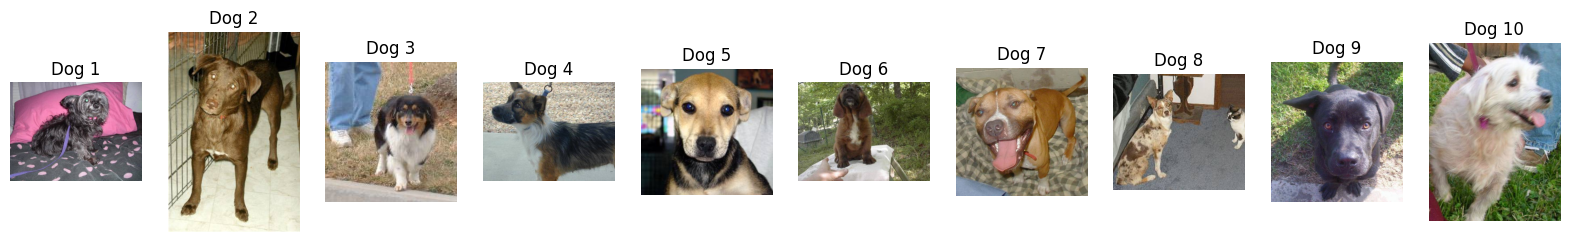

In [ ]:
# visualising the data for dogs

plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)
# adjusting the space between subplots with hspace -> height of padding between subplots


for i in range(10):
  plt.subplot(1,10,i+1)    # the number of images in the grid is 1*10 (10)
  filename = '/content/data/train/' + 'dog.' + str(i) + '.jpg'
  image = imread(filename)
  plt.imshow(image)
  plt.title(f'Dog {i+1}',fontsize=12)
  plt.axis('off')

plt.show()

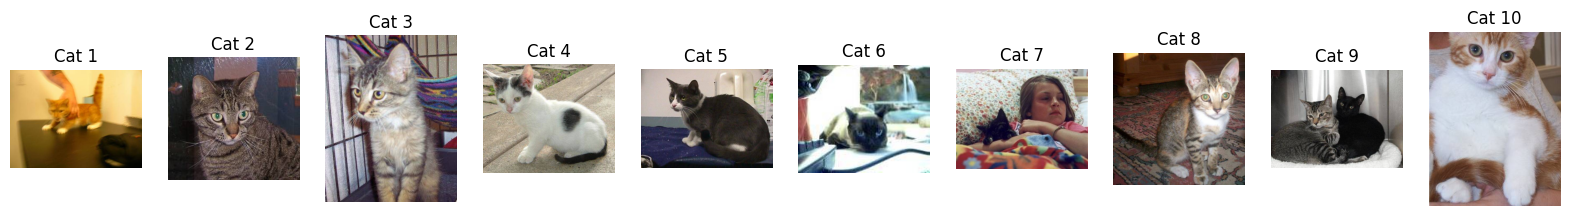

In [ ]:
# visualising the data for cats

plt.figure(figsize=(20,20)) # specifying the overall grid size
plt.subplots_adjust(hspace=0.4)
# adjusting the space between subplots with hspace -> height of padding between subplots


for i in range(10):
  plt.subplot(1,10,i+1)    # the number of images in the grid is 1*10 (10)
  filename = '/content/data/train/' + 'cat.' + str(i) + '.jpg'
  image = imread(filename)
  plt.imshow(image)
  plt.title(f'Cat {i+1}',fontsize=12)
  plt.axis('off')

plt.show()


In [ ]:
# train test split using dataframe
labels=data['label']

# train_test_split -> function of scikit-learn library used to split a data into 2 parts
# stratify -> used to return approx the same percentage of samples of each target class
# random_state -> controls shuffling applied to data before split
X_train, X_temp = train_test_split(data, test_size=0.2, stratify=labels, random_state=42)

label_test_val = X_temp['label']

# splitting X_temp into test and validating by 50%
X_test, X_val = train_test_split(X_temp, test_size=0.5, stratify=label_test_val, random_state = 42)

# shape is represented by a tuple -> (no of rows, no of cols)
print('The shape of train data',X_train.shape)
print('The shape of test data',X_test.shape)
print('The shape of validation data',X_val.shape)


The shape of train data (20000, 2)
The shape of test data (2500, 2)
The shape of validation data (2500, 2)


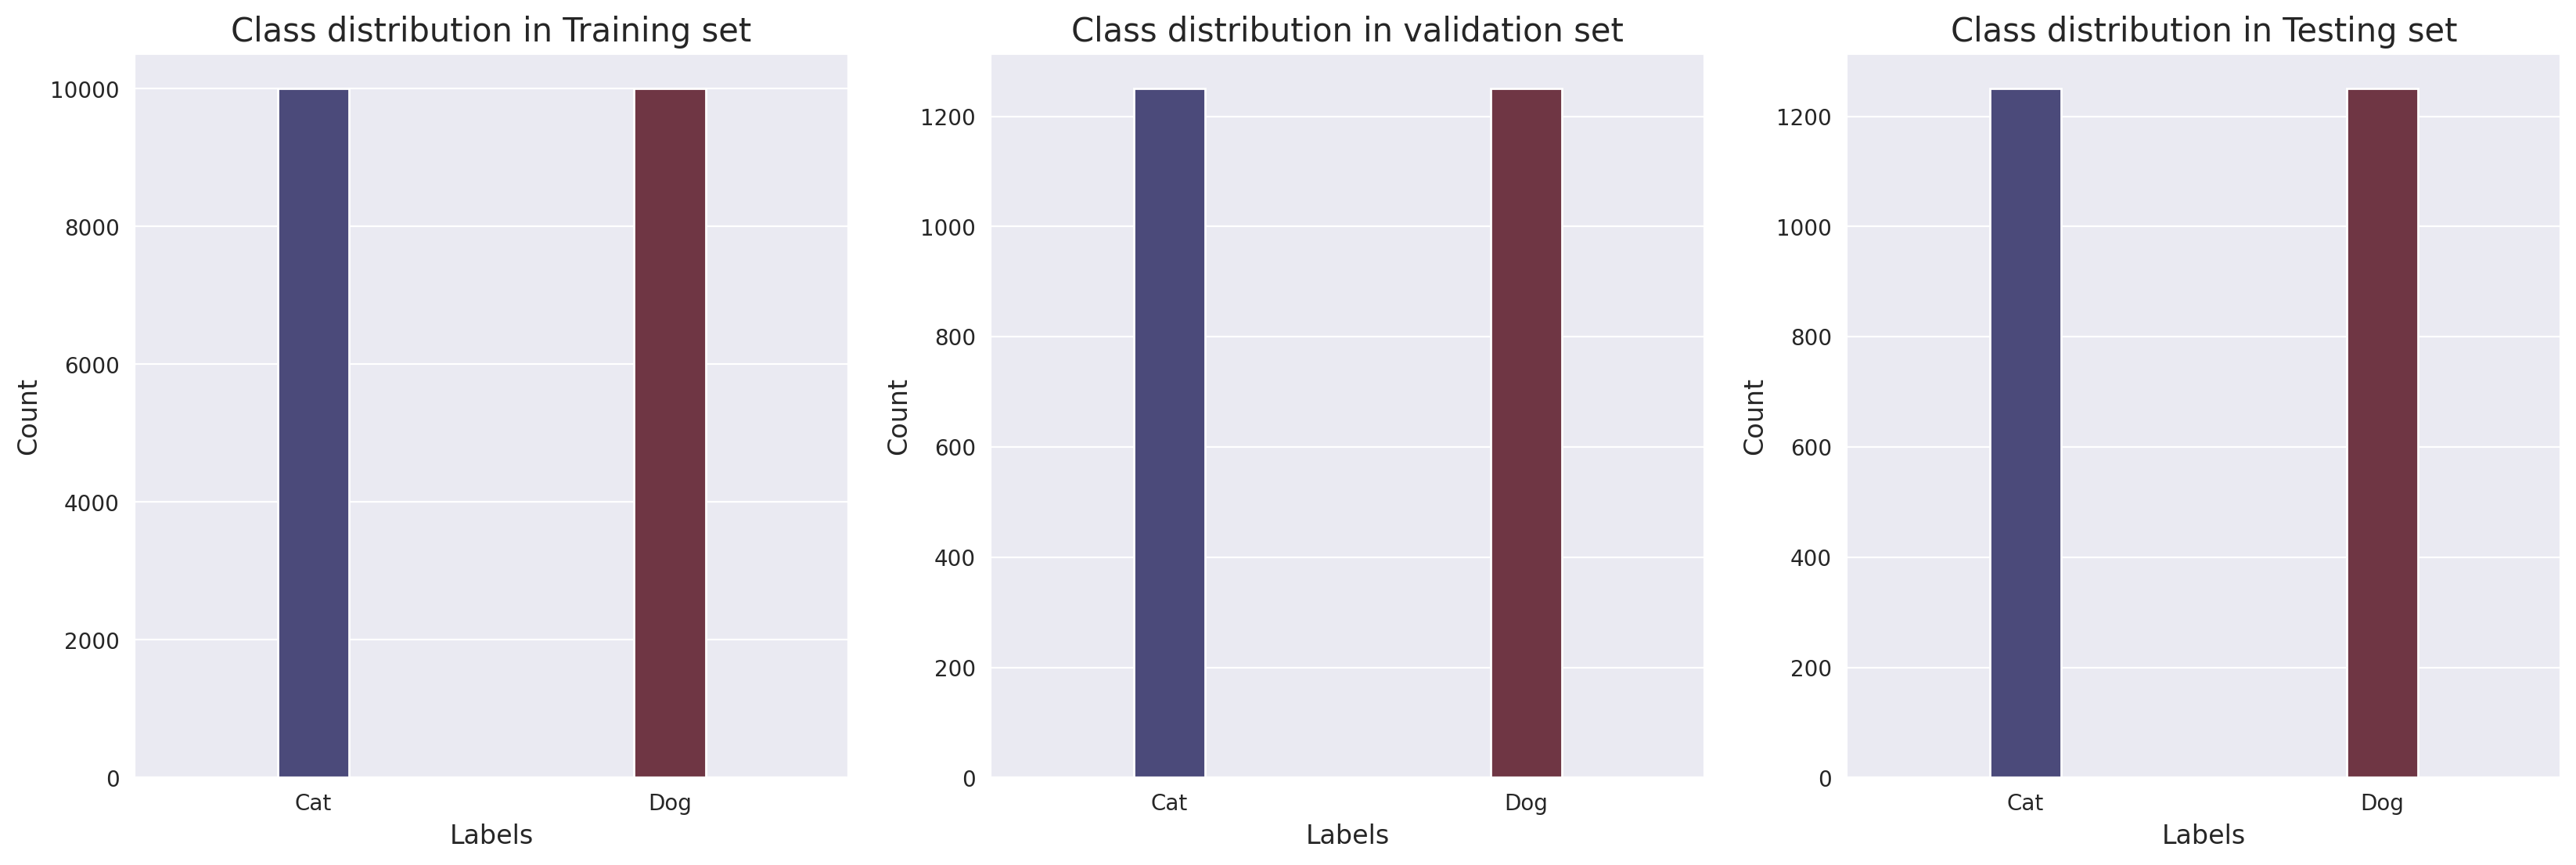

In [ ]:
# bar plot to see the class distribution in the training dataset
labels = ['Cat','Dog']

# unique is a function of numpy which returns sorted unique elements of the array
# alongside optional outputs such as no of counts of the value in the array
label1,count1 = np.unique(X_train.label,return_counts=True)
label2,count2 = np.unique(X_val.label,return_counts=True)
label3,count3 = np.unique(X_test.label,return_counts=True)


# loading data into the dataframe
uni1 = pd.DataFrame(data=count1,index=labels,columns=['Count1'])
uni2 = pd.DataFrame(data=count2,index=labels,columns=['Count2'])
uni3 = pd.DataFrame(data=count3,index=labels,columns=['Count3'])

# plotting the bargraphs using matplotlib
plt.figure(figsize=(20,6),dpi=200)
sns.set_style('darkgrid')

plt.subplot(131)
sns.barplot(data=uni1,x=uni1.index,y='Count1',palette='icefire',hue=uni1.index,width=0.2).set_title('Class distribution in Training set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.subplot(132)
sns.barplot(data=uni2,x=uni2.index,y='Count2',palette='icefire',hue=uni2.index,width=0.2).set_title('Class distribution in validation set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)


plt.subplot(133)
sns.barplot(data=uni3,x=uni3.index,y='Count3',palette='icefire',hue=uni3.index,width=0.2).set_title('Class distribution in Testing set',fontsize=15)
plt.xlabel('Labels',fontsize=12)
plt.ylabel('Count',fontsize=12)

plt.show()


In [ ]:
# create directories
dataset_home = '/content/data/'
subdirs = ['train2/', 'test2/']

for subdir in subdirs:
    # create label subdirectories
    labeldirs = ['dogs/', 'cats/']
    for labldir in labeldirs:
        newdir = dataset_home + subdir + labldir
        makedirs(newdir, exist_ok=True)
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2
# copy training dataset images into subdirectories
src_directory = '/content/data/train'
n=len(listdir(src_directory))
listFiles = listdir(src_directory)
for i in range(n):
    name=listFiles[i]
    src = src_directory + '/' + name
    dst_dir = 'train2/'
    if random() < val_ratio:
        dst_dir = 'test2/'
    if name.startswith('cat'):
        dst = dataset_home + dst_dir + 'cats/' + name
        copyfile(src, dst)
    elif name.startswith('dog'):
        dst = dataset_home + dst_dir + 'dogs/' + name
        copyfile(src, dst)



path1 = "/content/data/train2/cats"
path2 = "/content/data/train2/dogs"
path3 = "/content/data/test2/cats"
path4 = "/content/data/test2/dogs"


print('Then number of cat images in training data is' ,len(os.listdir(path1)))
print('Then number of dog images in training data is' ,len(os.listdir(path2)))
print('Then number of cat images in validation data is' ,len(os.listdir(path3)))
print('Then number of dog images in validation data is' ,len(os.listdir(path4)))

Then number of cat images in training data is 9949
Then number of dog images in training data is 9961
Then number of cat images in validation data is 2551
Then number of dog images in validation data is 2539


In [ ]:
# parameters
image_size = 128 # resolution of the image is (128,128)
image_channel = 3 # refers to rgb images
bat_size = 32 # number of samples processed by the model at a time during training

In [ ]:
# Creating image data generator

# ImageDataGenerator is a function used to preprocess the images on the fly
# during the model training.

# rescale scales down the image with each pixel containing value from 0 to 1.

# rotation_range randomly rotates in + or - direction of the value to create
# variability in the training data and make model more robust to rotations.



train_datagen = ImageDataGenerator(rescale=1./255,
                                    rotation_range = 15,
                                    horizontal_flip = True,
                                    zoom_range = 0.2,
                                    shear_range = 0.1,
                                    fill_mode = 'reflect',
                                    width_shift_range = 0.1,
                                    height_shift_range = 0.1)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
# Applying image data gernerator to train and test data

train_generator = train_datagen.flow_from_dataframe(X_train,
                                                    directory = '/content/data/train/',
                                                    x_col= 'filename',
                                                    y_col= 'label',
                                                    batch_size = bat_size,
                                                    target_size = (image_size,image_size)
                                                   )
val_generator = test_datagen.flow_from_dataframe(X_val,
                                                 directory = '/content/data/train/',
                                                 x_col= 'filename',
                                                 y_col= 'label',
                                                 batch_size = bat_size,
                                                 target_size = (image_size,image_size),
                                                 shuffle=False
                                                )

test_generator = test_datagen.flow_from_dataframe(X_test,
                                                  directory = '/content/data/train/',
                                                  x_col= 'filename',
                                                  y_col= 'label',
                                                  batch_size = bat_size,
                                                  target_size = (image_size,image_size),
                                                  shuffle=False
                                                 )

Found 20000 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


In [ ]:
train_gen = train_datagen.flow_from_directory('/content/data/train2/',
                                              class_mode='binary',
                                              target_size = (image_size,image_size),
                                              batch_size = bat_size,
                                             )

val_gen = test_datagen.flow_from_directory('/content/data/test2/',
                                          class_mode='binary',
                                          batch_size = bat_size,
                                          target_size = (image_size,image_size),
                                          shuffle = False
                                         )

Found 19910 images belonging to 2 classes.
Found 5090 images belonging to 2 classes.


In [ ]:
model = Sequential()

# Input Layer
model.add(Conv2D(32,(3,3),activation='relu',input_shape = (image_size,image_size,image_channel)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Block 1
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 2
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))
# Block 3
model.add(Conv2D(256,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fully Connected layers
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))

# Output layer
model.add(Dense(2,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 126, 126, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 63, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 61, 61, 64)        2

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy',
                                            patience=2,
                                            factor=0.5,
                                            min_lr = 0.00001,
                                            verbose = 1)

early_stoping = EarlyStopping(monitor='val_loss',patience= 3,restore_best_weights=True,verbose=0)



In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
cat_dog = model.fit(train_generator,
                    validation_data = val_generator,
                    callbacks=[early_stoping,learning_rate_reduction],
                    epochs = 30,
                    # steps_per_epoch = len(train_generator),
                    # validation_steps = len(val_generaotor),
                   )

Epoch 1/30
625/625 [==============================] - 127s 187ms/step - loss: 0.6361 - accuracy: 0.6757 - val_loss: 0.7441 - val_accuracy: 0.6576 - lr: 0.0010
Epoch 2/30
625/625 [==============================] - 113s 181ms/step - loss: 0.4911 - accuracy: 0.7689 - val_loss: 0.4678 - val_accuracy: 0.7648 - lr: 0.0010
Epoch 3/30
625/625 [==============================] - 113s 181ms/step - loss: 0.4218 - accuracy: 0.8026 - val_loss: 0.4903 - val_accuracy: 0.7720 - lr: 0.0010
Epoch 4/30
625/625 [==============================] - 116s 185ms/step - loss: 0.3689 - accuracy: 0.8336 - val_loss: 0.3333 - val_accuracy: 0.8584 - lr: 0.0010
Epoch 5/30
625/625 [==============================] - 114s 183ms/step - loss: 0.3278 - accuracy: 0.8575 - val_loss: 0.4056 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 6/30
625/625 [==============================] - 114s 182ms/step - loss: 0.3061 - accuracy: 0.8684 - val_loss: 0.2384 - val_accuracy: 0.9064 - lr: 0.0010
Epoch 7/30
625/625 [==========================

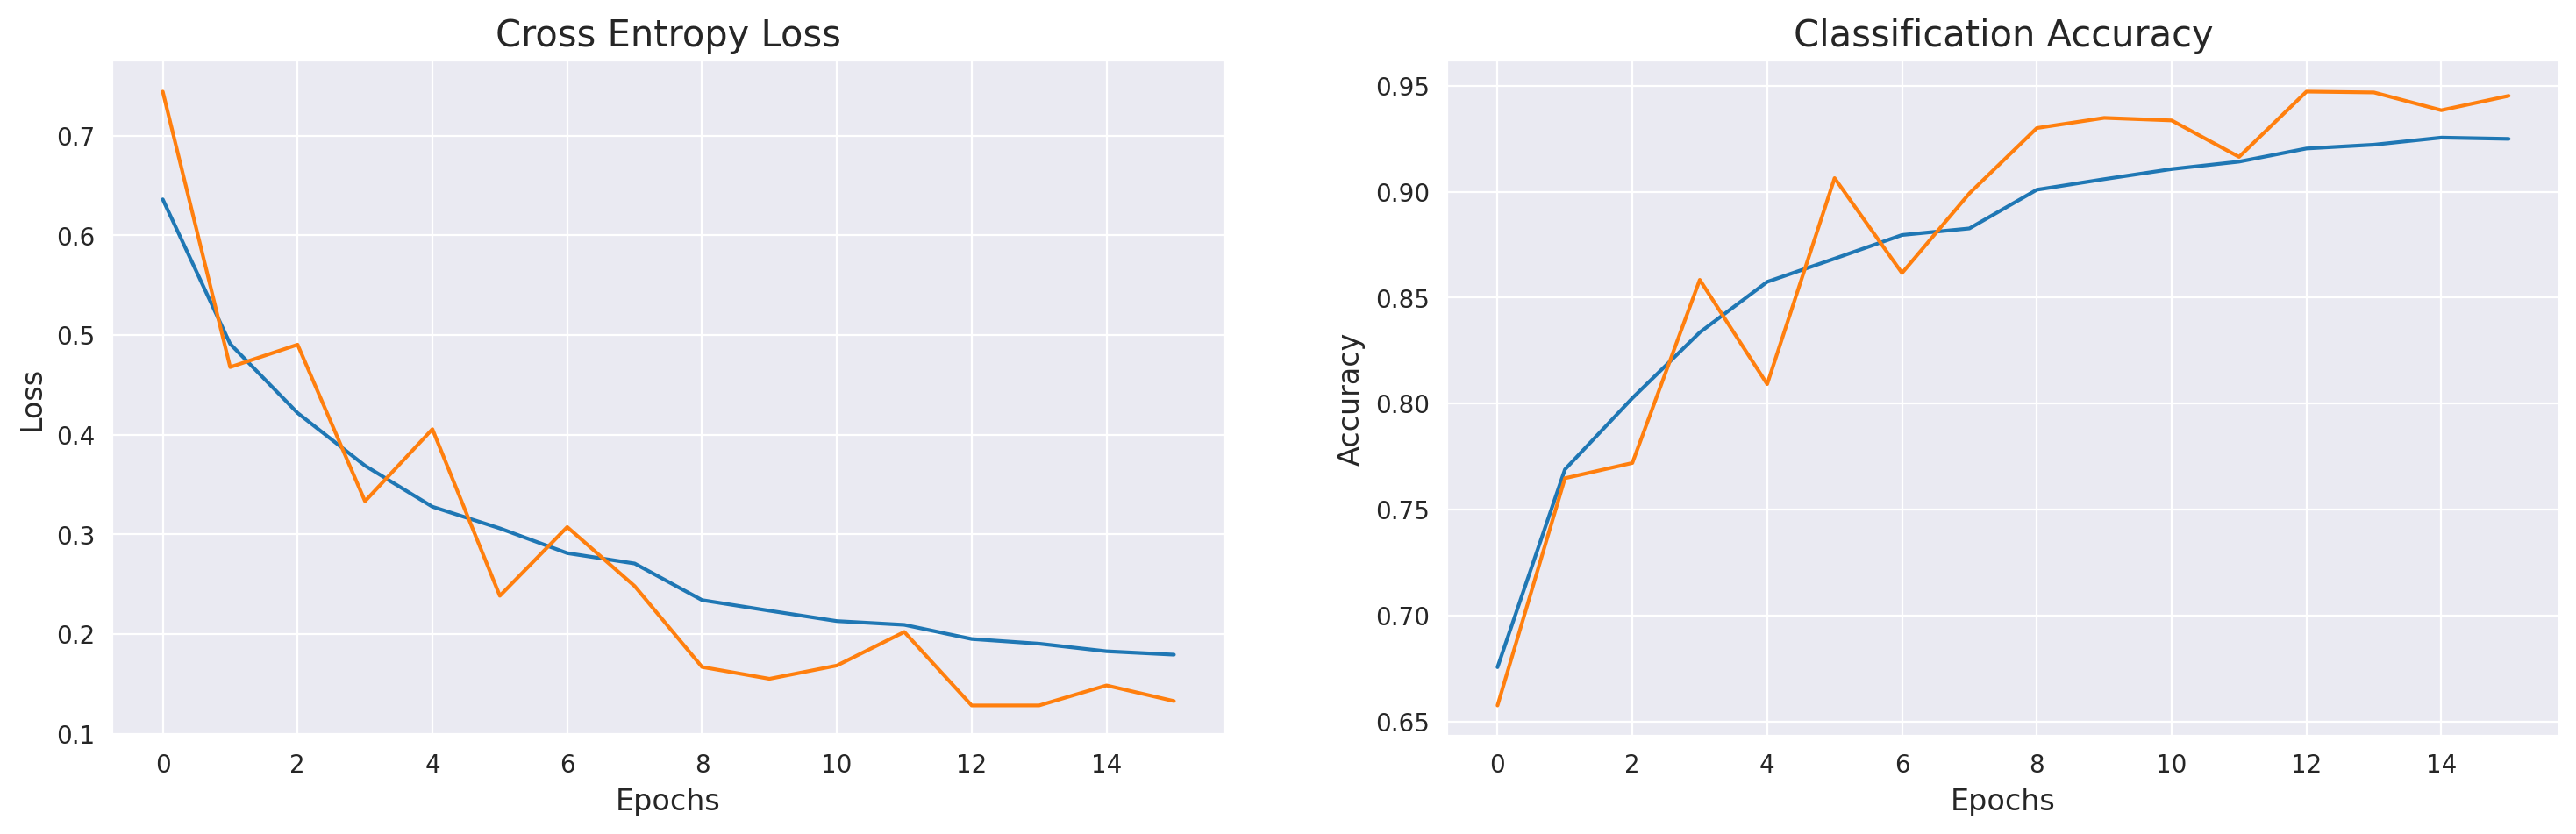

In [ ]:
# plots for accuracy and Loss with epochs

error = pd.DataFrame(cat_dog.history)

plt.figure(figsize=(18,5),dpi=200)
sns.set_style('darkgrid')

plt.subplot(121)
plt.title('Cross Entropy Loss',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Loss',fontsize=12)
plt.plot(error['loss'])
plt.plot(error['val_loss'])

plt.subplot(122)
plt.title('Classification Accuracy',fontsize=15)
plt.xlabel('Epochs',fontsize=12)
plt.ylabel('Accuracy',fontsize=12)
plt.plot(error['accuracy'])
plt.plot(error['val_accuracy'])

plt.show()

In [ ]:
# Evaluvate for train generator
loss,acc = model.evaluate(train_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for training data is:',acc*100)
print('The Loss of the model for training data is:',loss)

# Evaluvate for validation generator
loss,acc = model.evaluate(val_generator,batch_size = bat_size, verbose = 0)

print('The accuracy of the model for validation data is:',acc*100)
print('The Loss of the model for validation data is:',loss)

The accuracy of the model for training data is: 94.21499967575073
The Loss of the model for training data is: 0.1490749567747116
The accuracy of the model for validation data is: 96.16000056266785
The Loss of the model for validation data is: 0.10179269313812256


In [ ]:
# Save the Model
model.save("/content/gdrive/MyDrive/softComputing/")

In [ ]:
#loading the model
model = load_model("/content/gdrive/MyDrive/softComputing/")

In [ ]:
# prediction
result = model.predict(test_generator,batch_size = bat_size,verbose = 0)

y_pred = np.argmax(result, axis = 1)

y_true = test_generator.labels

# Evaluvate
loss,acc = model.evaluate(test_generator, batch_size = bat_size, verbose = 0)

print('The accuracy of the model for testing data is:',acc*100)
print('The Loss of the model for testing data is:',loss)

The accuracy of the model for testing data is: 94.91999745368958
The Loss of the model for testing data is: 0.12411902844905853


In [ ]:
labels =['Cat','Dog']
print(classification_report(y_true, y_pred,target_names=labels))

              precision    recall  f1-score   support

         Cat       0.94      0.95      0.95      1250
         Dog       0.95      0.94      0.95      1250

    accuracy                           0.95      2500
   macro avg       0.95      0.95      0.95      2500
weighted avg       0.95      0.95      0.95      2500



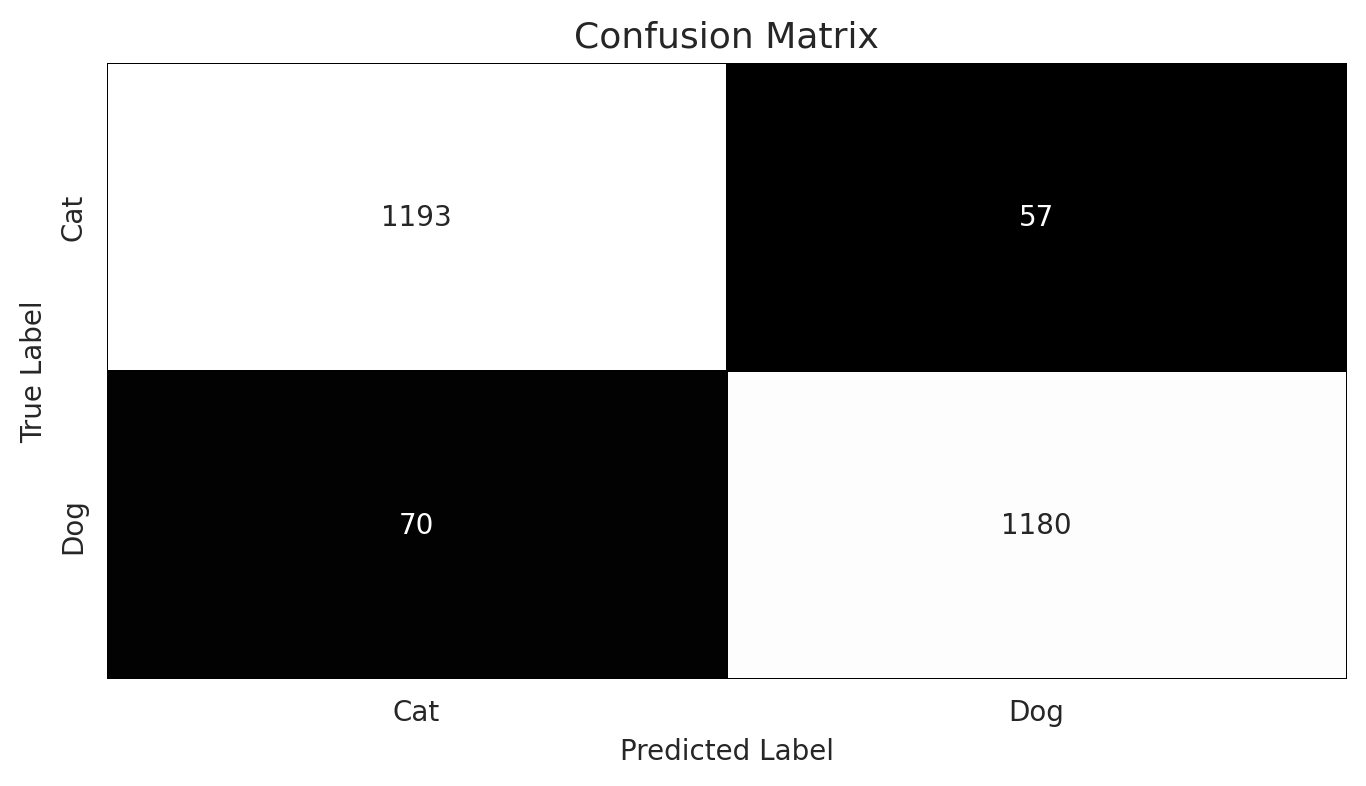

In [ ]:
confusion_mtx = confusion_matrix(y_true,y_pred)

f,ax = plt.subplots(figsize = (8,4),dpi=200)
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="black", fmt='.0f', ax=ax,cbar=False, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Label",fontsize=10)
plt.ylabel("True Label",fontsize=10)
plt.title("Confusion Matrix",fontsize=13)

plt.show()


In [ ]:
size =(128,128)

# loading into dataframe
test_dir = "/content/data/test1/"
filenames = os.listdir(test_dir)
test_data = pd.DataFrame({"filename": filenames})
test_data['label'] = 'unknown'

# Create data genenerator for test data
test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     "/content/data/test1/",
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = bat_size,
                                     target_size=size,
                                     shuffle = False)

# Test Prediction
test1_predict = model.predict(test1_idg,verbose = 0)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax

test_data['label'] = y_test_pred

# mapping
label_mapping = {0: 'cat', 1: 'dog'}
test_data['label'] = test_data['label'].map(label_mapping)
test_data.head()

# csv file output for submission
sub = pd.read_csv('/content/data/sampleSubmission.csv',index_col='id')

sub['label'] = y_test_pred

sub.to_csv('submission.csv',index=True)

Found 12500 validated image filenames belonging to 1 classes.


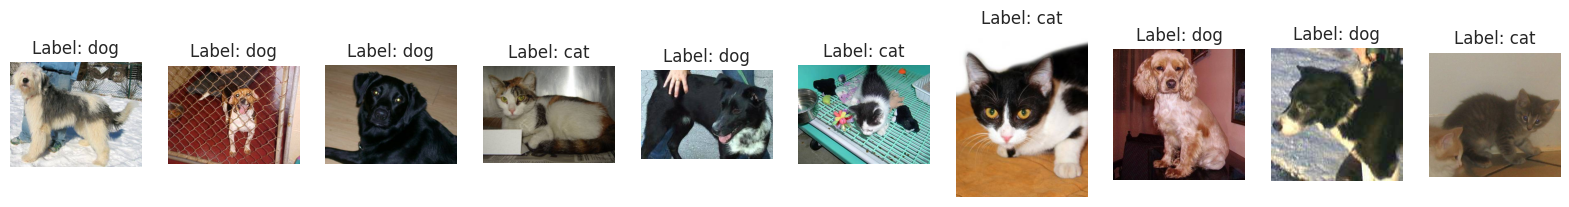

In [ ]:
fig, axes = plt.subplots(1, 10, figsize=(20, 4))
for idx in range(10):
    image_path = os.path.join(test_dir, test_data.iloc[idx]['filename'])
    image = Image.open(image_path)
    axes[idx].imshow(image)
    axes[idx].set_title("Label: " + test_data.iloc[idx]['label'])
    axes[idx].axis('off')
plt.show()

In [ ]:
# Real time input
!mkdir rti/

In [ ]:
!pip install requests

In [ ]:
import requests
from PIL import Image

def downloadImg(url:str):
    image_url = url
    filename = "/content/rti/test.jpg"

    # Download the image content
    response = requests.get(image_url)

    # Check for successful download
    if response.status_code == 200:
        # Save the image content as a file
        with open(filename, 'wb') as f:
            f.write(response.content)
        print(f"Image downloaded successfully: {filename}")
    else:
        print(f"Error downloading image: {response.status_code}")


In [ ]:
link=input(f"Paste the link of image: ")
downloadImg(link)

Paste the link of image: https://thumbor.forbes.com/thumbor/fit-in/900x510/https://www.forbes.com/advisor/wp-content/uploads/2023/07/top-20-small-dog-breeds.jpeg.jpg
Image downloaded successfully: /content/rti/test.jpg


Found 1 validated image filenames belonging to 1 classes.


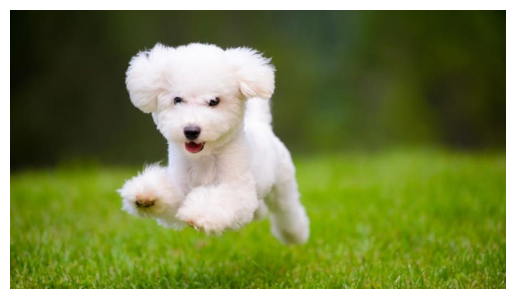

Dog


In [ ]:
size = (128,128)

test_dir="/content/rti"
filenames=listdir(test_dir)
test_data=pd.DataFrame({"filename":filenames})
test_data['label']="unknown"

test1_idg =  test_datagen.flow_from_dataframe(test_data,
                                     "/content/rti/",
                                     x_col= "filename",
                                     y_col = 'label',
                                     batch_size = bat_size,
                                     target_size=size,
                                     shuffle = False)

test1_predict = model.predict(test1_idg,verbose = 0)

test1_predict_argmax = np.argmax(test1_predict, axis=1)

y_test_pred = test1_predict_argmax[0]

if y_test_pred == 0:
    animal="Cat"
else:
    animal="Dog"

img = plt.imread('/content/rti/test.jpg')
plt.imshow(img)
plt.axis('off')  # Hide unnecessary axes
plt.show()
print(animal)